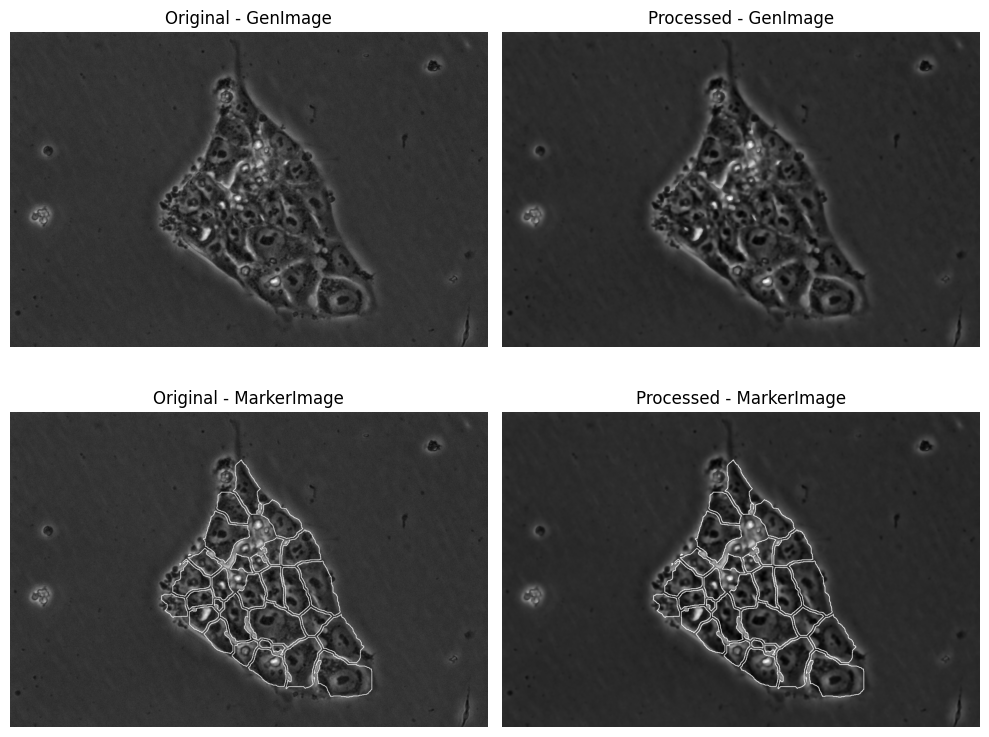

In [6]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import cv2

def compute_gradients(image):
    """Computes image gradients using finite difference kernels."""
    kernels = [
        np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]], np.float64),  # North
        np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]], np.float64),  # South
        np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]], np.float64),  # East
        np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]], np.float64)   # West
    ]
    return [convolve(image, k, mode='nearest') for k in kernels]

def perona_malik_conduction(gradients, kappa, method='quadratic'):
    """Computes the conduction coefficient for each gradient direction."""
    if method == 'quadratic':
        return [np.exp(-(g / kappa) ** 2) for g in gradients]
    elif method == 'exponential':
        return [1 / (1 + (g / kappa) ** 2) for g in gradients]
    else:
        raise ValueError("Invalid conduction method. Use 'quadratic' or 'exponential'.")

def update_image(image, gradients, conduction_coeffs, delta_t):
    """Updates the image based on computed diffusion terms."""
    diffusion = sum(c * g for c, g in zip(conduction_coeffs, gradients))
    return image + delta_t * diffusion

def perona_malik_diffusion(image, iterations, delta_t, kappa, method='quadratic'):
    """Applies Perona-Malik anisotropic diffusion to an image."""
    image = image.astype(np.float64)
    for _ in range(iterations):
        gradients = compute_gradients(image)
        conduction_coeffs = perona_malik_conduction(gradients, kappa, method)
        image = update_image(image, gradients, conduction_coeffs, delta_t)
    return np.clip(image, 0, 255).astype(np.uint8)


def apply_perona_malik(image_path, iterations=20, delta_t=0.1, kappa=20, method='quadratic'):
    """Loads an image, applies Perona-Malik diffusion, and returns the processed image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not read {image_path}. Check if the file exists.")
        return None

    processed = perona_malik_diffusion(image, iterations, delta_t, kappa, method)
    return image, processed  # Return both original and processed images


def main():
    image_paths = ["genimage.tif", "markerimage.tif"]
    titles = ["Original - GenImage", "Processed - GenImage", "Original - MarkerImage", "Processed - MarkerImage"]

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Create a 2x2 grid of subplots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, image_path in enumerate(image_paths):
        original, processed = apply_perona_malik(image_path, iterations=20, delta_t=0.1, kappa=20, method='quadratic')

        if original is not None and processed is not None:
            axes[2*i].imshow(original, cmap='gray')
            axes[2*i].set_title(titles[2*i])
            axes[2*i].axis("off")  # Hide axes

            axes[2*i+1].imshow(processed, cmap='gray')
            axes[2*i+1].set_title(titles[2*i+1])
            axes[2*i+1].axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
